In [44]:
# Import der benötigten Bibliotheken
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Lade den Datensatz
df = pd.read_csv('car_price_dataset.csv')

# Zeige die ersten 5 Zeilen, um die Struktur zu verstehen
print(df.head())

# Prüfe, ob es fehlende Werte gibt
print(df.isnull().sum())  # Falls Spalten mit NaN auftauchen, müssen wir sie behandeln
# 📌 2️⃣ Feature-Engineering
df["Car_Age"] = 2025 - df["Year"]
df["Mileage_Sqrt"] = np.sqrt(df["Mileage"]) * -1  # Negativer Einfluss erzwingen
df["Mileage_log"] = np.log1p(df["Mileage"])

# Owner_Count als KATEGORIE statt Zahl
df["Owner_Category"] = pd.cut(df["Owner_Count"], bins=[0,1,3,10], labels=["Few", "Normal", "Many"])
df["Owner_Category"] = LabelEncoder().fit_transform(df["Owner_Category"])  # Kategorien in Zahlen umwandeln

# Kategorische Daten encoden
categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# 📌 3️⃣ Skalierung der numerischen Features
scaler = StandardScaler()
numerical_cols = ["Car_Age", "Mileage_Sqrt", "Mileage_log", "Engine_Size", "Doors", "Owner_Category", "Price"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 📌 4️⃣ Features & Zielvariable definieren
X = df.drop(columns=["Price", "Year", "Mileage", "Owner_Count"])
y = np.abs(df["Price"])  # Negative Preise ins Positive umwandeln

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



        Brand   Model  Year  Engine_Size Fuel_Type    Transmission  Mileage  \
0         Kia     Rio  2020          4.2    Diesel          Manual   289944   
1   Chevrolet  Malibu  2012          2.0    Hybrid       Automatic     5356   
2    Mercedes     GLA  2020          4.2    Diesel       Automatic   231440   
3        Audi      Q5  2023          2.0  Electric          Manual   160971   
4  Volkswagen    Golf  2003          2.6    Hybrid  Semi-Automatic   286618   

   Doors  Owner_Count  Price  
0      3            5   8501  
1      2            3  12092  
2      4            2  11171  
3      2            1  11780  
4      3            3   2867  
Brand           0
Model           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64


In [45]:
# 📌 5️⃣ Hyperparameter-Tuning für Random Forest
param_grid = {
    'n_estimators': [100, 300],  # Anzahl Bäume
    'max_depth': [10, 20, None],  # Tiefe des Baums
    'min_samples_split': [2, 5],  # Mindestanzahl Samples für Split
    'min_samples_leaf': [1, 2]  # Mindestanzahl Samples pro Blatt
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Beste Hyperparameter für Random Forest:", grid_search.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Beste Hyperparameter für Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [46]:
# 📌 6️⃣ Bestes Random Forest Modell mit besten Parametern trainieren
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# 📌 7️⃣ Gradient Boosting trainieren (keine Hyperparameter-Suche nötig)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

# 📌 8️⃣ Modellbewertung
def evaluate_model(y_test, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"🔥 {name} → RMSE: {rmse:.2f}, R²: {r2:.4f}")

evaluate_model(y_test, y_pred_rf, "Optimierter Random Forest")
evaluate_model(y_test, y_pred_gbr, "Gradient Boosting")


🔥 Optimierter Random Forest → RMSE: 0.17, R²: 0.9121
🔥 Gradient Boosting → RMSE: 0.29, R²: 0.7429


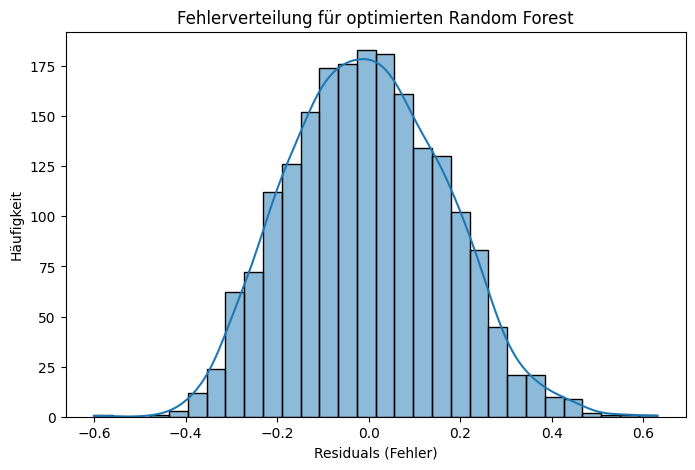

In [47]:
# 📌 9️⃣ Fehlerverteilung analysieren
errors_rf = y_test - y_pred_rf
plt.figure(figsize=(8, 5))
sns.histplot(errors_rf, bins=30, kde=True)
plt.xlabel("Residuals (Fehler)")
plt.ylabel("Häufigkeit")
plt.title("Fehlerverteilung für optimierten Random Forest")
plt.show()

                Importance
Engine_Size       0.231552
Car_Age           0.227809
Mileage_log       0.182005
Mileage_Sqrt      0.153713
Transmission      0.083867
Fuel_Type         0.078303
Model             0.017064
Brand             0.012240
Doors             0.007879
Owner_Category    0.005568


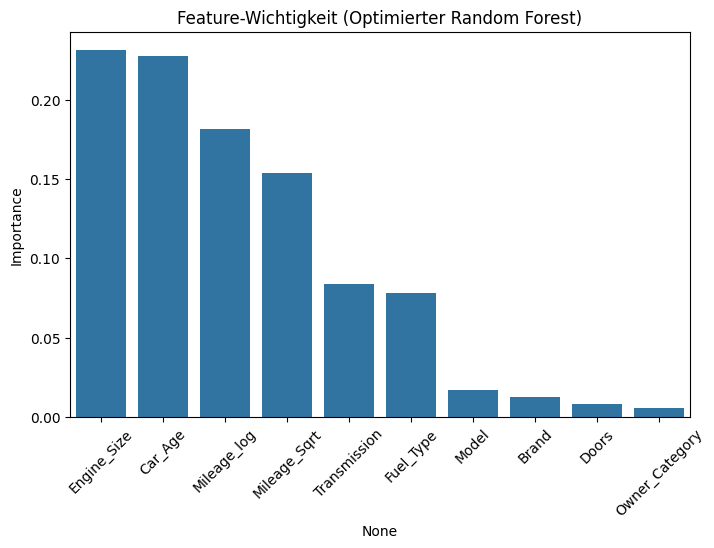

In [48]:
# 📌 🔟 Feature-Wichtigkeit für optimierten Random Forest
feature_importances = pd.DataFrame(best_rf.feature_importances_, index=X.columns, columns=["Importance"])
feature_importances.sort_values(by="Importance", ascending=False, inplace=True)
print(feature_importances)

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances.index, y=feature_importances["Importance"])
plt.xticks(rotation=45)
plt.title("Feature-Wichtigkeit (Optimierter Random Forest)")
plt.show()
